In [14]:
# Imports for our GNN regression model implementation

import torch
import torch_geometric
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d, Flatten, Module
from torch_scatter import scatter_mean
from torch.utils.data import random_split
from torch_geometric.data import DataListLoader, Batch
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import random

sys.path.insert(0, '../src/')
from GraphDataset import GraphDataset
from load_data import path_generator

ROOT = "/home/h8lee/DSC180B-A11-Project/src"

%matplotlib inline

In [2]:
import yaml

with open(os.path.join(ROOT, '../conf/reg_defs.yml')) as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
# nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
# ntracks = definitions['ntracks']

In [3]:
train_files = (random.sample(path_generator('signal', eda=False), 6) + 
                   random.sample(path_generator('qcd', eda=False), 6))
dir_path = '/home/h8lee/DSC180B-A11-Project'

In [5]:
# from RegDataGenerator import DataGenerator
# train_files = ['/teams/DSC180A_FA21_A00/a11/train_mass_hbb/BulkGravitonToHHTo4Q_MX-600to6000_MH-15to250_part1_TuneCP5_13TeV-madgraph_pythia8/nano_mc2017_1-1_Skim.root']
# dir_path = '/home/h8lee/DSC180B-A11-Project/'

# Optimize runtime
graph_dataset = GraphDataset(dir_path, features, labels, spectators, n_events=1000, n_events_merge=1, 
                             file_names= train_files)

Processing...


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Done!


In [10]:
def collate(items):
    l = sum(items, [])
    return Batch.from_data_list(l)

torch.manual_seed(0)
valid_frac = 0.20
full_length = len(graph_dataset)
valid_num = int(valid_frac*full_length)
batch_size = 32

train_dataset, valid_dataset = random_split(graph_dataset, [full_length-valid_num,valid_num])

train_loader = DataListLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
train_loader.collate_fn = collate
valid_loader = DataListLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
valid_loader.collate_fn = collate

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)

/opt/conda/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataListLoader' is deprecated, use 'loader.DataListLoader' instead
  warnings.warn(out)


In [11]:
# Fixable

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer = Seq(Lin(30, 32),
                         Lin(32, 200), # Double, Fix the number of neurons
                         BatchNorm1d(200),
                         Lin(200, 200),
                         BatchNorm1d(200),
                         Lin(200, 200),
                         BatchNorm1d(200),
                         Lin(200, 64),
                         BatchNorm1d(64),
                         Lin(64, 32),
                         BatchNorm1d(32),
                         ReLU(),
                         Lin(32,1))

    def forward(self, x, batch):
        out = scatter_mean(x, batch, dim=0)
        return self.layer(out)
    
# net = Net().to(device)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.02)

In [26]:
n_epochs = 100
t = tqdm(range(0, n_epochs))

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
# TRAINING CELL

lst = []
valid_lst = []
best_vloss = float(np.inf)
net = Net().to(device) # Model initialization
optimizer = torch.optim.Adam(net.parameters(), lr=0.02)
valid_pred_loss = float(np.inf)
stopper = False

for epoch in t:
    if stopper:
        break;
    
    p = tqdm(enumerate(train_loader), total=train_samples/batch_size, leave=bool(epoch==n_epochs-1))
    q = tqdm(enumerate(valid_loader), total=valid_samples/batch_size, leave=bool(epoch==n_epochs-1))
    
    loss_func = nn.MSELoss() # Mean Squared Error to track learning 
    if (epoch > 0) & (os.path.exists('simplenetwork_best.pt')):
        # We restore the weights configured for the model from first epoch
        net.load_state_dict(torch.load('simplenetwork_best.pt'))

    temp = []
    valid_temp = []
    net.train() # Training starts
#     net.eval() # IDK
    for i, data in p:
        data = data.to(device) # Moving data to memory
        y = data.y # Retrieving target variable
        prediction = net(data.x, data.batch) # `data` being used here should be validation set
        loss = loss_func(prediction.float(), y.float()) # Will this be training loss or validation loss
        temp.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # Updating optimizer
    
    batch_loss = np.average(temp)
    lst.append(batch_loss)
#     valid_batch_loss = np.average(valid_temp)
#     valid_lst.append(valid_batch_loss)
    
    net.eval(); # Validation starts
    for j, vdata in q:
        vdata = vdata.to(device)
        y = vdata.y
        vpreds = net(vdata.x, vdata.batch)
        vloss = loss_func(vpreds.float(), y.float())
        
        valid_temp.append(vloss.item())
        
    batch_vloss = np.average(valid_temp)
    valid_lst.append(batch_vloss)
    
    if batch_vloss < best_vloss:
        best_vloss = batch_vloss
        modpath = os.path.join('simplenetwork_best.pt')
        print('New best model saved to:',modpath)
        torch.save(net.state_dict(),modpath)
    
    if (epoch > 25) & (batch_vloss > valid_pred_loss):
        stopper = True
    else:
        valid_pred_loss = batch_vloss
        
    print(f'At epoch {epoch}, training loss: {batch_loss} and validation loss: {batch_vloss}')

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

New best model saved to: simplenetwork_best.pt


  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

New best model saved to: simplenetwork_best.pt


  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

New best model saved to: simplenetwork_best.pt


  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

New best model saved to: simplenetwork_best.pt


  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

New best model saved to: simplenetwork_best.pt


  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

New best model saved to: simplenetwork_best.pt


  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

New best model saved to: simplenetwork_best.pt


  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

New best model saved to: simplenetwork_best.pt


  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

New best model saved to: simplenetwork_best.pt


  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

New best model saved to: simplenetwork_best.pt


  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

  0%|          | 0/25.0 [00:00<?, ?it/s]

  0%|          | 0/6.25 [00:00<?, ?it/s]

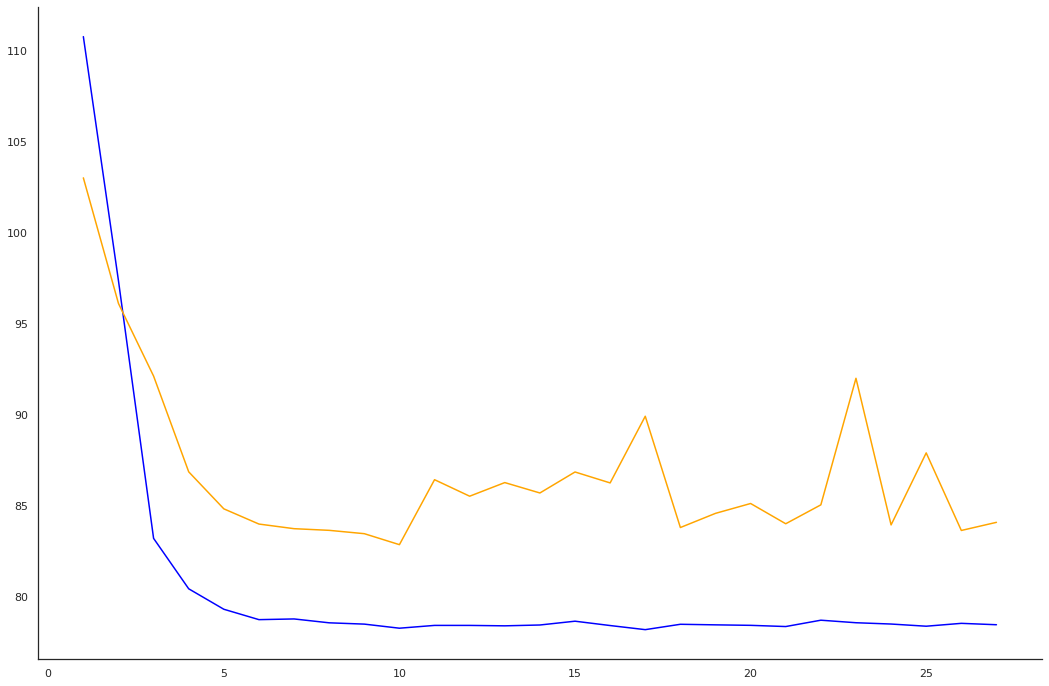

In [29]:
valid_rmse = [np.sqrt(x) for x in valid_lst]
train_rmse = [np.sqrt(x) for x in lst]
epoch = [x+1 for x in range(len(valid_rmse))]

fig = plt.figure(figsize=(18,12))
ax = fig.gca()
_ = sns.set(context='notebook',
           rc={'axes.spines.right':False,
              'axes.spines.top':False},
           style='white')

sns.lineplot(x=epoch, y=train_rmse, color='blue', ax=ax)
sns.lineplot(x=epoch, y=valid_rmse, color='orange', ax=ax);

In [28]:
def plotter(lst):
    x = range(1, len(lst)+1, 1)
    fig = plt.figure(figsize=(18,12))
    ax = fig.gca()
    
    ax = sns.lineplot(x, lst, color='blue', alpha=0.4)
    return ax

In [19]:
valid_lst

[11160.4033203125,
 8758.598074776786,
 7645.519670758928,
 78983.14006696429,
 6885.562430245535,
 7319.102748325893,
 7174.56689453125,
 6966.092075892857,
 6902.305524553572,
 6925.738490513393,
 6873.183384486607,
 7118.124720982143,
 6889.022739955357,
 15650.512276785714,
 18875.720842633928,
 7341.510881696428,
 18782.91378348214,
 9595.91734095982,
 8398.705984933036,
 7544.740792410715,
 15934.193917410714,
 10264.262765066964,
 8015.349958147322,
 17041.793108258928,
 18500.4853515625,
 9021.55894252232,
 11145.91810825893,
 10198.635184151786,
 23499.10770089286,
 6857.651436941965,
 8670.710170200893,
 8459.208984375,
 14277.93247767857]

In [20]:
lst

[12282.66611328125,
 9433.59458984375,
 6854.222451171875,
 6458.22736328125,
 6318.6759765625,
 6222.02669921875,
 6185.950009765625,
 6180.138134765625,
 6156.358994140625,
 6157.542236328125,
 6120.89896484375,
 6137.451328125,
 6153.35154296875,
 6079.714736328125,
 6173.570234375,
 6116.1234375,
 6207.113798828125,
 6213.8298828125,
 6149.362626953125,
 6265.271259765625,
 6232.3587890625,
 6158.836767578125,
 6183.713798828125,
 6185.32599609375,
 6177.4544921875,
 6160.747587890625,
 6093.405322265625,
 6185.21623046875,
 6114.18236328125,
 6178.040390625,
 6152.511728515625,
 6117.49541015625,
 6112.967802734375]

In [12]:
lst

[59568.73984375,
 52791.26515625,
 43150.436328125,
 37705.73265625,
 36400.33328125,
 36588.056328125,
 36163.061875,
 36040.3215625]

In [12]:
lst

[11585.3248828125,
 8948.7143359375,
 6875.442177734375,
 6342.92619140625,
 6123.60416015625,
 6060.99939453125,
 6036.7575,
 6005.0105859375]

In [13]:
[np.sqrt(x) for x in lst]

[107.63514706085786,
 94.5976444523726,
 82.91828614807699,
 79.64248986192138,
 78.25346101071985,
 77.8524206080405,
 77.69657328351103,
 77.49200336768627]

----

In [ ]:
def test(net, data_loader, data_samples, batch_size, n_epochs):
    net.eval()
    t = tqdm(enumerate(data_loader), total=data_samples/batch_size, leave=bool(epoch==n_epochs-1))
    loss_func = nn.L1Loss()
    #track total loss, track batch mean, track number of batches
    data_mean = 0
    total_loss = 0
    batches = 0
    #
    for i, data in t:
        data = data.to(device)
        y = data.y
        prediction = net(data.x, data.batch)
        loss = loss_func(prediction.float(), y.float())
        # add batch mean to total, add loss
        data_mean += torch.mean(data.x)
        total_loss += loss
        batches += 1
        #
        t.refresh()
    return total_loss/(data_mean/batches)

## RUN THE WEIGHTED MODEL ON TEST SET

In [ ]:
# Early stopper: When validation loss stops decreasing

In [ ]:
inputs = 19
hidden = 40
outputs = 1

class Edge(torch.nn.Module):
    def __init__:
    def forward():
        
class NodeBlock(torch.nn.Module):
    def __init__:
    def forward():
        
class GlobalBlock(torch.nn.Module):
    def __init__:
    def forward():
        
class InteractionNetwork(torch.nn.Module):
    def __init__:
    def forward():
        

In [ ]:
test_files = ["/home/h8lee/teams/DSC180A_FA21_A00/a11/test_mass_hbb/BulkGravitonToHHTo4Q_MX-600to6000_MH-15to250_part1_TuneCP5_13TeV-madgraph_pythia8/nano_mc2017_3-10_Skim.root"]
#delete old processed files
dir_path = '/home/h8lee/DSC180B-A11-Project/test/'
try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))
test_dataset = GraphDataset(dir_path, features, labels, spectators, n_events=2000, n_events_merge=1, 
                            file_names=test_files)

test_loader = DataListLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader.collate_fn = collate
test_samples = len(test_dataset)

In [ ]:
y_test = []
y_predict = []
t = tqdm(enumerate(test_loader), total=train_samples/batch_size, leave=bool(epoch==n_epochs-1))
for i,data in t:
    data = data.to(device)    
    batch_output = net(data.x, data.batch)    
    y_predict.append(batch_output.detach().cpu().numpy())
    y_test.append(data.y.cpu().numpy())
y_test = np.concatenate(y_test)
y_predict = np.concatenate(y_predict)

In [ ]:
#rmse
np.sqrt(np.mean((y_test - y_predict) ** 2))